Configurações iniciais

In [4]:
#Importação de módulos

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [5]:
# Dados
scaler = StandardScaler()

mnist = load_digits()
X, y = scaler.fit_transform(mnist.data), mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Treinamento do modelo baseado em árvore de decisão

In [6]:
param = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Imprimir a precisão da Decision Tree
print("Precisão:", best_clf.score(X_test, y_test))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Melhores hiperparâmetros: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Precisão: 0.8462962962962963


Avaliação dos ganhos com a utilização de modelos Ensemble

In [7]:
#Adaboost
ada_clf = AdaBoostClassifier(n_estimators=50, algorithm='SAMME',random_state=42)
ada_clf.fit(X_train, y_train)

#XGBoost
xgb_clf = XGBClassifier(n_estimators=50, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

#Random Forest
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
rf_clf.fit(X_train, y_train)

#Enseble
voting_clf = VotingClassifier(
    estimators=[
        ('ada', ada_clf),
        ('xgb', xgb_clf),
        ('rf', rf_clf)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Ensemble model: {accuracy:.4f}')


Accuracy of Ensemble model: 0.9648


Visualização da árvore de decisão e Medida de Impureza

In [8]:
def plotArvore(model,title):
    plt.figure(figsize=(20,10))
    plot_tree(model, filled=True, feature_names=[f'pixel_{i}' for i in range(X.shape[1])], class_names=[str(i) for i in range(10)])
    plt.title(title)
    plt.show()

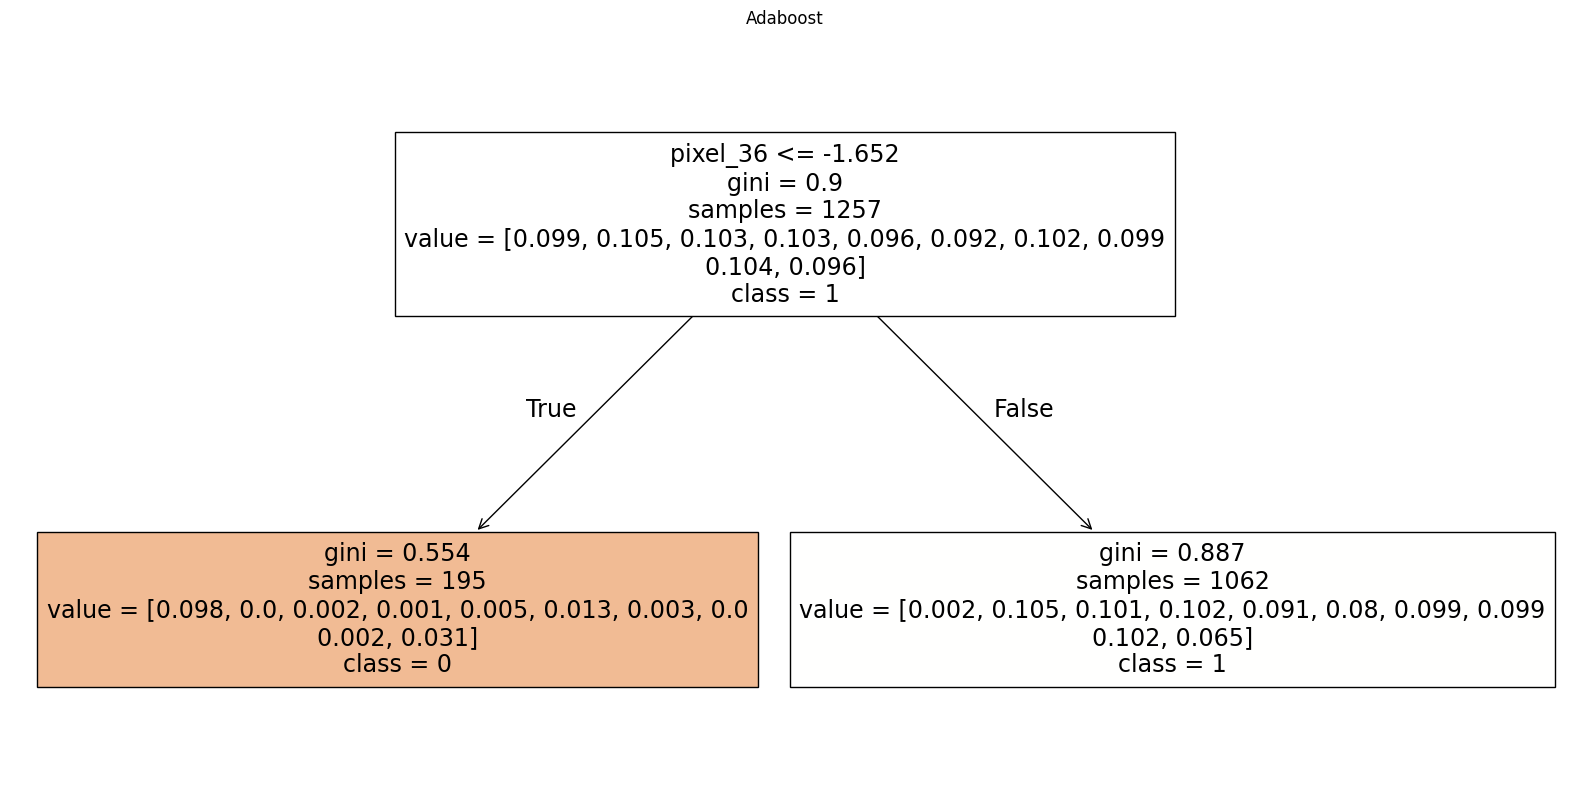

In [10]:
plotArvore(ada_clf.estimators_[0],"Adaboost")


In [11]:
# Medidas de impureza

def gini_impurity(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return 1 - np.sum(probabilities ** 2)

def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities))

print(f'Gini Impurity : {gini_impurity(y_pred):.4f}')
print(f'Entropy: {entropy(y_pred):.4f}')

Gini Impurity : 0.8988
Entropy: 3.3133


In [12]:
model_path = 'models/model.pkl'
joblib.dump(voting_clf, model_path)

['models/model.pkl']